# Dependências

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

import json
import itertools

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

# Global variables

In [2]:
results_path = '../res/forecasting_results'

# Funções auxiliares

In [3]:
def fix_precision_recall_fscore(file_name, pos_label='1.0', neg_label='-1.0'):
    data = None

    with open(os.path.join(results_path, file_name), 'r') as f:
        data = json.load(f)

        for currency in data:
            for label in data[currency]:                
                for mode in data[currency][label]:                    
                    for windows_size in data[currency][label][mode]:
                        # Create windows_size metrics array
                        windows_precisions = []
                        windows_recalls = []
                        windows_f1s = []

                        neg_windows_precisions = []
                        neg_windows_recalls = []
                        neg_windows_f1s = []

                        macro_windows_precisions = []
                        macro_windows_recalls = []
                        macro_windows_f1s = []

                        # Get tests labels
                        test_labels = data[currency][label][mode][windows_size]['test_labels']
                        
                        # Iterate over all pred_labels
                        for pred_labels in data[currency][label][mode][windows_size]['pred_labels']:
                            # Binary metrics for class pos_label
                            precision, recall, f1, _ = precision_recall_fscore_support(
                                test_labels, pred_labels, average='binary', pos_label=pos_label
                            )
                            
                            windows_precisions.append(precision)
                            windows_recalls.append(recall)
                            windows_f1s.append(f1)

                            # Binary metrics for class neg_label
                            precision, recall, f1, _ = precision_recall_fscore_support(
                                test_labels, pred_labels, average='binary', pos_label=neg_label
                            )
                            
                            neg_windows_precisions.append(precision)
                            neg_windows_recalls.append(recall)
                            neg_windows_f1s.append(f1)

                            # Macro metrics
                            precision, recall, f1, _ = precision_recall_fscore_support(
                                test_labels, pred_labels, average='macro'
                            )
                            
                            macro_windows_precisions.append(precision)
                            macro_windows_recalls.append(recall)
                            macro_windows_f1s.append(f1)

                        # Save pos_label metrics
                        data[currency][label][mode][windows_size]['precision'] = windows_precisions
                        data[currency][label][mode][windows_size]['recall'] = windows_recalls
                        data[currency][label][mode][windows_size]['f1'] = windows_f1s

                        # Save neg_label metrics
                        data[currency][label][mode][windows_size]['neg_precision'] = neg_windows_precisions
                        data[currency][label][mode][windows_size]['neg_recall'] = neg_windows_recalls
                        data[currency][label][mode][windows_size]['neg_f1'] = neg_windows_f1s

                        # Save macro metrics
                        data[currency][label][mode][windows_size]['macro_precision'] = macro_windows_precisions
                        data[currency][label][mode][windows_size]['macro_recall'] = macro_windows_recalls
                        data[currency][label][mode][windows_size]['macro_f1'] = macro_windows_f1s

    with open(os.path.join(results_path, file_name), 'w+') as f:
        f.write(json.dumps(data, indent=4))

In [6]:
def generate_results_table(file_name):
    data = None

    with open(os.path.join(results_path, file_name), 'r') as f:
        data = json.load(f)

        results = {}
        windows = None

        for currency in data:
            for label in data[currency]:
                for mode in data[currency][label]:
                    precisions = []
                    recalls = []
#                     f1s = []
                    accuracies = []

                    if windows is None:
                        windows = list(data[currency][label][mode].keys())

                    for windows_size in data[currency][label][mode]:
                        best_execution = np.array(data[currency][label][mode][windows_size]['accuracy']).argmax()
                        
                        accuracies.append(
                            str(
                                data[currency][label][mode][windows_size]['accuracy'][best_execution]
                            )[:6]
                        )

                        precisions.append(
                            str(
                                data[currency][label][mode][windows_size]['macro_precision'][best_execution]
                            )[:6]
                        )
                        recalls.append(
                            str(
                                data[currency][label][mode][windows_size]['macro_recall'][best_execution]
                            )[:6]
                        )
#                         f1s.append(
#                             str(
#                                 data[currency][label][mode][windows_size]['macro_f1'][best_execution]
#                             )[:6]
#                         )

                    zipped_data = list(zip(windows, precisions, recalls, accuracies))
                    results[mode] = (
                        '\\\\ \n'.join(
                            map(
                                ' & '.join,
                                zipped_data
                            )
                        )
                    )

#     print(results)
    return results

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    
#     max_ = None
#     min_ = None
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         if max_ is None or cm[i, j] > max_:
#             max_ = cm[i, j]
#         if min_ is None or cm[i, j] < min_:
#             min_ = cm[i, j]
        
    thresh = cm.max() - cm.min() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Rótulo verdadeiro')
    plt.xlabel('Rótulo previsto')
    plt.tight_layout()

def many_confusion_matrices(file_name, considered_windows=[]):
    with open(os.path.join(results_path, file_name), 'r') as f:
        data = json.load(f)

        for currency in data:
            for label in data[currency]:
                for mode in data[currency][label]:
                    for windows_size in data[currency][label][mode]:
                        if considered_windows and windows_size not in considered_windows:
                            continue

                        # Get tests labels
                        test_labels = data[currency][label][mode][windows_size]['test_labels']
                        
                        best_execution = np.array(data[currency][label][mode][windows_size]['accuracy']).argmax()
                        pred_labels = data[currency][label][mode][windows_size]['pred_labels'][best_execution]

                        # Compute confusion matrix
                        cnf_matrix = confusion_matrix(
                            test_labels,
                            pred_labels,
                            labels=['1.0', '-1.0']
                        )

                        # Plot normalized confusion matrix
                        plt.figure()
                        plot_confusion_matrix(cnf_matrix, classes=['1.0', '-1.0'], normalize=False,
                                              title='Modo ' + mode + ' com janela de tamanho ' + str(windows_size))

                        plt.show()

In [20]:
def additional_info(file_name, considered_windows=[]):
    with open(os.path.join(results_path, file_name), 'r') as f:
        data = json.load(f)

        for currency in data:
            for label in data[currency]:
                for mode in data[currency][label]:
                    for windows_size in data[currency][label][mode]:
                        if considered_windows and windows_size not in considered_windows:
                            continue
                        
                        best_execution = np.array(data[currency][label][mode][windows_size]['accuracy']).argmax()

                        print('Info for windows size:', windows_size)
                        p = np.array(data[currency][label][mode][windows_size]['precision'])
                        r = np.array(data[currency][label][mode][windows_size]['recall'])
                        f = np.array(data[currency][label][mode][windows_size]['f1'])
                        
                        print('\tpositive precision', p.mean(), p[best_execution])
                        print('\tpositive recall', r.mean(), r[best_execution])
                        print('\tpositive f1', f.mean(), f[best_execution])
                        
                        npr = np.array(data[currency][label][mode][windows_size]['neg_precision'])
                        nr = np.array(data[currency][label][mode][windows_size]['neg_recall'])
                        nf = np.array(data[currency][label][mode][windows_size]['neg_f1'])
                        
                        print('\tnegative precision', npr.mean(), npr[best_execution])
                        print('\tnegative recall', nr.mean(), nr[best_execution])
                        print('\tnegative f1', nf.mean(), nf[best_execution])

# Correção dos dados:

In [40]:
# H1
print('Fixing H1 files')
fix_precision_recall_fscore('aode-goodfilter.txt')

# H2
print('Fixing H2 files')
fix_precision_recall_fscore('aode-1250slice-goodfilter.txt')

# H3
print('Fixing H3 files')
fix_precision_recall_fscore('svm-pow5-1250slice-goodfilter.txt')
fix_precision_recall_fscore('rf-200-15ex-1250slice-goodfilter.txt')
fix_precision_recall_fscore('rf-500-15ex-1250slice-goodfilter.txt')
fix_precision_recall_fscore('mlp-60-100-40-1250slice-goodfilter.txt')

# H4
print('Fixing H4 files')
fix_precision_recall_fscore('df-500-1250slice-goodfilter.txt', pos_label='1', neg_label='0')
fix_precision_recall_fscore('df-200-1250slice-goodfilter.txt', pos_label='1', neg_label='0')

# Old filter
print('Fixing old filter')
fix_precision_recall_fscore('rf-200-15ex-1250slice.txt')
fix_precision_recall_fscore('rf-500-15ex-1250slice.txt')

print('Done')

Fixing H1 files
Fixing H2 files
Fixing H3 files
Fixing H4 files
Fixing old filter
Done


In [16]:
fix_precision_recall_fscore('bitcoin.txt')

# Tabelas de resultados

In [41]:
# H1
print('Table results for H1 files')
results = generate_results_table('aode-goodfilter.txt')

print('Paper:\n' + results['paper'])
print()

print('Count:\n' + results['count'])
print()

# H2
print('Table results for H2 files')
results = generate_results_table('aode-1250slice-goodfilter.txt')

print('Paper:\n' + results['paper'])
print()

print('Count:\n' + results['count'])
print()

# H3
print('Table results for H3 files')
results = generate_results_table('svm-pow5-1250slice-goodfilter.txt')
print('SVM:\n' + results['paper'])
print()

results = generate_results_table('rf-200-15ex-1250slice-goodfilter.txt')
print('RF 200:\n' + results['paper'])
print()

results = generate_results_table('rf-500-15ex-1250slice-goodfilter.txt')
print('RF 500:\n' + results['paper'])
print()

results = generate_results_table('mlp-1250slice-goodfilter.txt')
print('MLP:\n' + results['paper'])
print()

# H4
print('Table results for H4 files')
results = generate_results_table('df-200-1250slice-goodfilter.txt')
print('DF 200:\n' + results['paper'])
print()

results = generate_results_table('df-500-1250slice-goodfilter.txt')
print('DF 500:\n' + results['paper'])
print()

# Old filter
print('Table results for old filter files')
results = generate_results_table('rf-200-15ex-1250slice.txt')
print(results['paper'])
print()

results = generate_results_table('rf-500-15ex-1250slice.txt')
print(results['paper'])
print()

print('\nDone')

Table results for H1 files
Paper:
1 & 0.4963 & 0.4963 & 0.4960\\ 
2 & 0.4851 & 0.4852 & 0.4861\\ 
3 & 0.5329 & 0.5316 & 0.5335\\ 
4 & 0.5429 & 0.5425 & 0.5434\\ 
5 & 0.4905 & 0.4905 & 0.4910\\ 
6 & 0.5035 & 0.5035 & 0.5029\\ 
7 & 0.4838 & 0.4839 & 0.4831\\ 
8 & 0.4712 & 0.4712 & 0.4712\\ 
9 & 0.4747 & 0.4750 & 0.4742\\ 
10 & 0.5001 & 0.5001 & 0.5\\ 
11 & 0.4990 & 0.4990 & 0.5\\ 
12 & 0.4902 & 0.4902 & 0.4900\\ 
13 & 0.2465 & 0.5 & 0.4930\\ 
14 & 0.2465 & 0.5 & 0.4930\\ 
15 & 0.2465 & 0.5 & 0.4930\\ 
16 & 0.2465 & 0.5 & 0.4930\\ 
17 & 0.2470 & 0.5 & 0.4940\\ 
18 & 0.2470 & 0.5 & 0.4940\\ 
19 & 0.2470 & 0.5 & 0.4940\\ 
20 & 0.2470 & 0.5 & 0.4940\\ 
21 & 0.2475 & 0.5 & 0.4950\\ 
22 & 0.2475 & 0.5 & 0.4950\\ 
23 & 0.2475 & 0.5 & 0.4950\\ 
24 & 0.2475 & 0.5 & 0.4950\\ 
25 & 0.248 & 0.5 & 0.496\\ 
26 & 0.248 & 0.5 & 0.496\\ 
27 & 0.248 & 0.5 & 0.496\\ 
28 & 0.248 & 0.5 & 0.496\\ 
29 & 0.2474 & 0.5 & 0.4949\\ 
30 & 0.2474 & 0.5 & 0.4949\\ 
31 & 0.2474 & 0.5 & 0.4949\\ 
32 & 0.2474 & 0.5 & 0.4

MLP:
1 & 0.6497 & 0.5578 & 0.5618\\ 
2 & 0.45 & 0.4902 & 0.4948\\ 
3 & 0.5620 & 0.5590 & 0.5595\\ 
4 & 0.5374 & 0.5344 & 0.5336\\ 
5 & 0.5390 & 0.5389 & 0.5388\\ 
6 & 0.5142 & 0.5135 & 0.5129\\ 
7 & 0.5847 & 0.5794 & 0.5781\\ 
8 & 0.5575 & 0.5566 & 0.5572\\ 
9 & 0.5584 & 0.5578 & 0.5572\\ 
10 & 0.5417 & 0.5409 & 0.5416\\ 
11 & 0.5315 & 0.5266 & 0.5235\\ 
12 & 0.5345 & 0.5344 & 0.5340\\ 
13 & 0.5499 & 0.5499 & 0.5497\\ 
14 & 0.5310 & 0.5301 & 0.5287\\ 
15 & 0.5526 & 0.5498 & 0.5473\\ 
16 & 0.5298 & 0.5285 & 0.5263\\ 
17 & 0.5366 & 0.5366 & 0.5368\\ 
18 & 0.5419 & 0.5420 & 0.5421\\ 
19 & 0.5687 & 0.5677 & 0.5661\\ 
20 & 0.6135 & 0.6136 & 0.6137\\ 
21 & 0.5810 & 0.5789 & 0.5767\\ 
22 & 0.6029 & 0.6030 & 0.6031\\ 
23 & 0.5849 & 0.5825 & 0.5797\\ 
24 & 0.6069 & 0.6036 & 0.6063\\ 
25 & 0.5852 & 0.5853 & 0.5851\\ 
26 & 0.5897 & 0.5891 & 0.5904\\ 
27 & 0.5779 & 0.5779 & 0.5775\\ 
28 & 0.5998 & 0.5996 & 0.5989\\ 
29 & 0.5938 & 0.5938 & 0.5935\\ 
30 & 0.5824 & 0.5799 & 0.5775\\ 
31 & 0.5715 & 0.

# Informações adicionais

Confusion matrix, without normalization
[[65 27]
 [53 44]]


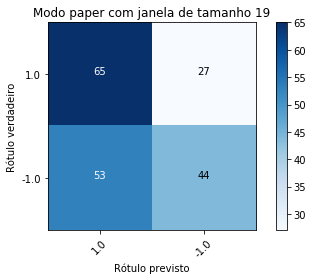

In [38]:
many_confusion_matrices('svm-pow5-1250slice-goodfilter.txt', ['19'])

In [25]:
additional_info('mlp-1250slice-goodfilter.txt', ['20', '22', '24', '26', '28'])
# additional_info('svm-pow5-1250slice-goodfilter.txt', ['19'])

Info for windows size: 20
	positive precision 0.5252772590823828 0.6021505376344086
	positive recall 0.5297101449275362 0.6086956521739131
	positive f1 0.525402091935008 0.6054054054054054
	negative precision 0.5505014858480984 0.625
	negative recall 0.545017182130584 0.6185567010309279
	negative f1 0.5456121655634913 0.6217616580310881
Info for windows size: 22
	positive precision 0.5353314786742793 0.5913978494623656
	positive recall 0.5833333333333334 0.5978260869565217
	positive f1 0.5577199297623456 0.5945945945945945
	negative precision 0.5668585499909184 0.6145833333333334
	negative recall 0.5182130584192439 0.6082474226804123
	negative f1 0.5407063357425871 0.61139896373057
Info for windows size: 24
	positive precision 0.5410614683342536 0.6103896103896104
	positive recall 0.556043956043956 0.5164835164835165
	positive f1 0.5460016992297666 0.5595238095238095
	negative precision 0.5715535149449177 0.6036036036036037
	negative recall 0.5546391752577319 0.6907216494845361
	negati

# Others

In [165]:
pred_labels = [
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0"
]

test_labels = [
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "1.0",
    "1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "-1.0",
    "1.0"
]

In [167]:
print(classification_report(test_labels, pred_labels))

             precision    recall  f1-score   support

       -1.0       0.67      0.16      0.26        97
        1.0       0.51      0.91      0.66        94

avg / total       0.59      0.53      0.46       191



In [184]:
accuracy_score(test_labels, pred_labels)

0.5340314136125655

In [173]:
print(classification_report(test_labels, inv_pred_labels))

             precision    recall  f1-score   support

       -1.0       0.49      0.84      0.61        97
        1.0       0.33      0.09      0.14        94

avg / total       0.41      0.47      0.38       191



In [182]:
accuracy_score(test_labels, inv_pred_labels)

0.46596858638743455

In [168]:
precision_recall_fscore_support(
    test_labels, pred_labels, average='binary', pos_label='1.0'
)

(0.5149700598802395, 0.9148936170212766, 0.6590038314176244, None)

In [169]:
precision_recall_fscore_support(
    test_labels, pred_labels, average='binary', pos_label='-1.0'
)

(0.6666666666666666, 0.16494845360824742, 0.2644628099173554, None)

In [170]:
precision_recall_fscore_support(
    test_labels, pred_labels, average='weighted'
)

(0.5920096978817234, 0.5340314136125655, 0.4586348309698438, None)

In [171]:
precision_recall_fscore_support(
    test_labels, pred_labels, average='macro'
)

(0.590818363273453, 0.539921035314762, 0.4617333206674899, None)